In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

tf.random.set_seed(42)
np.random.seed(42)

In [2]:
from sklearn.datasets import load_sample_image

china = load_sample_image("china.jpg") / 255.
flower = load_sample_image("flower.jpg") / 255.

images = np.array([china,flower])
batch_size, height, width, channels = images.shape

# using receptive field 7x7 for every channel, 2 for 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1 # vertical line
filters[3, :, :, 1] = 1 # horizontal line

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-04-17 15:08:24.014827: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-17 15:08:24.014938: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


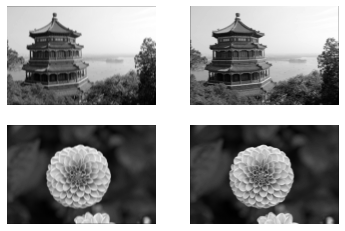

In [3]:
import matplotlib.pyplot as plt

i = 1
for img_idx in (0, 1):
    for map_idx in (0, 1):
        plt.subplot(2, 2, i)
        plt.imshow(outputs[img_idx, :, :, map_idx], cmap="gray")
        plt.axis("off")
        i += 1

plt.show()

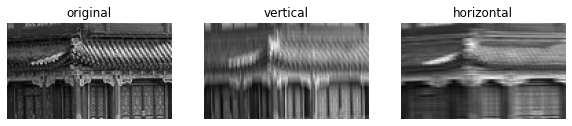

In [4]:
def crop(img):
    return img[150:220, 130:250]

i = 1
plt.figure(figsize=(10, 5))
for name, img in (("original", images[0, :, :, 0]), ("vertical", outputs[0, :, :, 0]), ("horizontal", outputs[0, :, :, 1])):
    img = crop(img)
    plt.subplot(1, 3, i)
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.title(name)
    i += 1

plt.show()

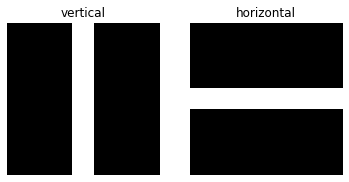

In [5]:
i = 1
for name, filter in (("vertical", filters[:, :, 0, 0]), ("horizontal", filters[:, :, 0, 1])):
    plt.subplot(1, 2, i)
    plt.imshow(filter, cmap="gray")
    plt.title(name)
    plt.axis("off")
    i += 1 
plt.show()

In [6]:
# 32 filters each one 3x3
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="same", activation="relu")

In [7]:
# POOLING

max_pool = keras.layers.MaxPool2D(pool_size=2)
cropped_img = np.array([crop(img) for img in images], dtype=np.float32)
output = max_pool(cropped_img)

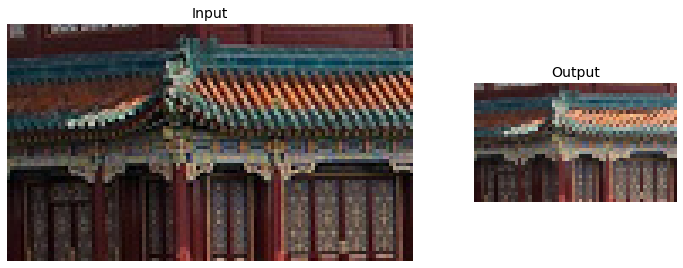

In [8]:
import matplotlib as mpl

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_img[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

In [9]:
# depthwise max pooling
# (batch, width, height, depth)
# note - depth stride should be the devisor of input depth

with tf.device("/cpu:0"):
    output = tf.nn.max_pool(images, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3), padding="VALID")

In [10]:
# to use with model
depth_pool = keras.layers.Lambda(
    lambda X: tf.nn.max_pool(X, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3), padding="VALID"),
)

In [11]:
avg_pool = keras.layers.AvgPool2D(pool_size=2)

In [12]:
# like average pooling but with spatial dimensions like input dimensions
global_avg_pool = keras.layers.GlobalAvgPool2D()

In [13]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_val, y_val = X_train_full[-5000:], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_val = (X_val - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

In [14]:
# add channel dimension

X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [15]:
from functools import partial

DefaultConv2D = partial(
    keras.layers.Conv2D,
    kernel_size=3, 
    activation="relu",
    padding="SAME",
)

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28,28, 1]),
    keras.layers.MaxPool2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPool2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"), 
    keras.layers.Dropout(0.5), 
    keras.layers.Dense(units=64, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation="softmax")
])

callbacks = [keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), batch_size=64)


In [16]:
DefaultConv2D = partial(
    keras.layers.Conv2D,
    kernel_size=5, 
    activation="tanh",
    strides=1
)
DefaultPool2D = partial(
    keras.layers.AvgPool2D,
    pool_size=2, 
    strides=2,
)

def create_LeNet(name="LeNet-5"):

    def get_run_logdir():
        import time, os
        root_logdir = os.path.join(os.curdir, "my_logs")
        run_id =  time.strftime(f"{name}_run_%Y_%m_%d-%H_%M_%S")
        return os.path.join(root_logdir, run_id)


    model = keras.models.Sequential([
        keras.layers.Input(shape=[32, 32, 1]),
        DefaultConv2D(filters=6),
        DefaultPool2D(),
        DefaultConv2D(filters=16),
        DefaultPool2D(),
        DefaultConv2D(filters=120),
        keras.layers.Flatten(),
        keras.layers.Dense(84, activation="tanh"),
        keras.layers.Dense(10, activation="softmax")
        
    ])

    model.compile(
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
        optimizer="nadam"
    )

    run_logdir = get_run_logdir()
    callbacks = [
        keras.callbacks.EarlyStopping(patience=2),
        keras.callbacks.TensorBoard(run_logdir),
        keras.callbacks.ModelCheckpoint(f"{name}.h5", save_best_only=True)
    ]
    
    return model, callbacks

In [17]:
model, callbacks = create_LeNet()

In [18]:
X_train_p = np.pad(X_train, ((0, 0), (2, 2), (2, 2), (0, 0)))
X_val_p = np.pad(X_val, ((0, 0), (2, 2), (2, 2), (0, 0)))

In [19]:
X_train.shape, X_train_p.shape

((55000, 28, 28, 1), (55000, 32, 32, 1))

model.fit(X_train_p, y_train, epochs=100, callbacks=callbacks, batch_size=128, validation_data=(X_val_p, y_val))

In [20]:
DefaultConv2D = partial(
    keras.layers.Conv2D,
    kernel_size=3, 
    activation="relu",
    padding="SAME",
    strides=1
)
DefaultPool2D = partial(
    keras.layers.MaxPool2D,
    pool_size=2, # original 3, but our set is unseperable by 3
    strides=2,
    padding="VALID",
)

# for much larger datasets than mnist, on each its overfitts
def create_AlexNet(name="AlexNet"):

    def get_run_logdir():
        import time, os
        root_logdir = os.path.join(os.curdir, "my_logs")
        run_id =  time.strftime(f"{name}_run_%Y_%m_%d-%H_%M_%S")
        return os.path.join(root_logdir, run_id)


    model = keras.models.Sequential([
        keras.layers.Input(shape=[28, 28, 1]),

        # they require cpu 
        # keras.layers.RandomRotation(factor=0.1), # data augumentation, onlu for training
        # keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2), # data augumentation, onlu for training

        DefaultConv2D(filters=96, kernel_size=11, strides=4, padding="VALID"),
        tf.keras.layers.Lambda(tf.nn.local_response_normalization),
        DefaultPool2D(),
        DefaultConv2D(filters=256, kernel_size=5),
        tf.keras.layers.Lambda(tf.nn.local_response_normalization),
        DefaultPool2D(),
        DefaultConv2D(filters=384),
        DefaultConv2D(filters=384),
        DefaultConv2D(filters=256),
        keras.layers.Flatten(),
        keras.layers.Dense(4096, activation="relu"),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(4096, activation="relu"),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
        optimizer="nadam"
    )

    run_logdir = get_run_logdir()
    callbacks = [
        keras.callbacks.EarlyStopping(patience=2),
        keras.callbacks.TensorBoard(run_logdir),
        keras.callbacks.ModelCheckpoint(f"{name}.h5", save_best_only=True)
    ]
    
    return model, callbacks

In [21]:
model, callbacks = create_AlexNet()

model.fit(X_train, y_train, epochs=100, callbacks=callbacks, batch_size=128, validation_data=(X_val, y_val))

In [22]:
# currently more popular option

# for much larger datasets than mnist, on each its overfitts
def create_AlexNet2(name="AlexNet2"):
    def get_run_logdir():
        import time, os
        root_logdir = os.path.join(os.curdir, "my_logs")
        run_id =  time.strftime(f"{name}_run_%Y_%m_%d-%H_%M_%S")
        return os.path.join(root_logdir, run_id)


    model = keras.models.Sequential([
        keras.layers.Input(shape=[28, 28, 1]),

        # they require cpu 
        # keras.layers.RandomRotation(factor=0.1), # data augumentation, onlu for training
        # keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2), # data augumentation, onlu for training

        DefaultConv2D(filters=96, kernel_size=11, strides=4, padding="VALID"),
        keras.layers.BatchNormalization(),
        tf.keras.layers.Lambda(tf.nn.local_response_normalization),
        DefaultPool2D(),
        DefaultConv2D(filters=256, kernel_size=5),
        keras.layers.BatchNormalization(),
        tf.keras.layers.Lambda(tf.nn.local_response_normalization),
        DefaultPool2D(),
        DefaultConv2D(filters=384),
        keras.layers.BatchNormalization(),
        DefaultConv2D(filters=384),
        keras.layers.BatchNormalization(),
        DefaultConv2D(filters=256),
        keras.layers.BatchNormalization(),
        DefaultPool2D(),
        keras.layers.Flatten(),
        keras.layers.Dense(4096, activation="relu"),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(4096, activation="relu"),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
        optimizer="nadam"
    )

    run_logdir = get_run_logdir()
    callbacks = [
        keras.callbacks.EarlyStopping(patience=2),
        keras.callbacks.TensorBoard(run_logdir),
        keras.callbacks.ModelCheckpoint(f"{name}.h5", save_best_only=True)
    ]
    
    return model, callbacks

model, callbacks = create_AlexNet()
model.fit(X_train, y_train, epochs=100, callbacks=callbacks, batch_size=128, validation_data=(X_val, y_val))

In [23]:
# loading a pretrained models
model = keras.applications.resnet50.ResNet50(weights="imagenet")

In [24]:
# to preserce the aspect ration use crop_and_resize()

images_resized = tf.image.resize(images, [224, 224])

In [25]:
images_resized = tf.image.resize_with_pad(images, 224, 224, antialias=True)
images_resized = tf.image.resize_with_crop_or_pad(images, 224, 224)

In [26]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)
Y_proba = model.predict(inputs)

2022-04-17 15:08:29.227013: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-17 15:08:29.602708: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [27]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, 3)
for image_index in range(len(images)): 
    print(f"Image {image_index}")
    for class_id, name, y_proba in top_K[image_index]:
        print(f"\t{class_id} - {name:12s} {y_proba:.2f}%")
    print()

Image 0
	n03877845 - palace       0.92%
	n03781244 - monastery    0.05%
	n02825657 - bell_cote    0.01%

Image 1
	n04522168 - vase         0.38%
	n07930864 - cup          0.09%
	n11939491 - daisy        0.08%



In [28]:
import tensorflow_datasets as tfds

(test_set_raw, valid_set_raw, train_set_raw), info = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True,
    with_info=True
    )

/Users/user/miniforge3/envs/ML_metal/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [45]:
LABELS =info.features['label'].names

2022-04-17 15:08:31.112308: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


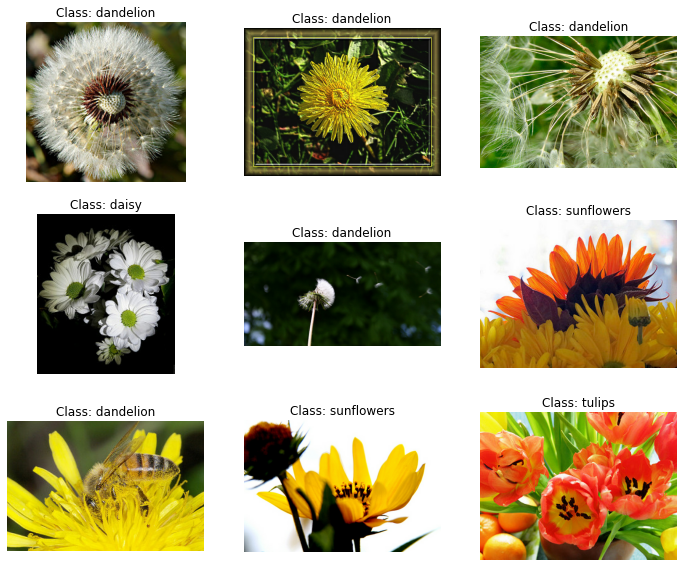

In [30]:
plt.figure(figsize=(12, 10))
idx = 0
for img, label in train_set_raw.take(9):
    idx += 1
    plt.subplot(3, 3, idx)
    plt.imshow(img)
    plt.title(f"Class: {LABELS[label]}")
    plt.axis("off")
plt.show()

In [36]:
def preprocess(image, label):
    image = tf.image.central_crop(image, 0.8)
    image = tf.image.resize(image, [224, 224])
    image = tf.image.random_flip_left_right(image, seed=123)
    image = tf.image.random_flip_up_down(image, seed=123)
    image = tf.image.rot90(image, k=np.random.randint(1, 5))

    image = keras.applications.xception.preprocess_input(image)
    return image, label


In [72]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 64

train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(preprocess).batch(BATCH_SIZE).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(BATCH_SIZE).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(BATCH_SIZE).prefetch(1)

2022-04-17 15:22:57.374797: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


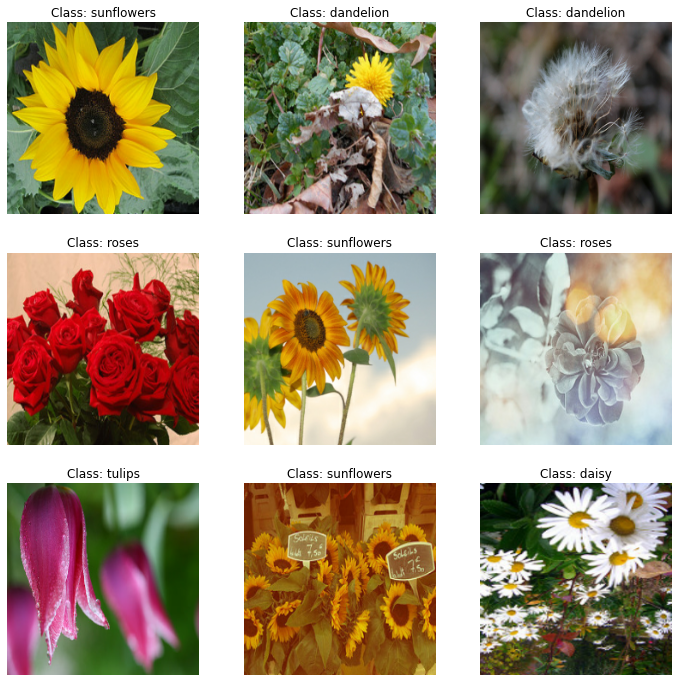

In [73]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for idx in range(9):
        plt.subplot(3, 3, idx+1)
        plt.imshow(X_batch[idx] / 2 + 0.5)
        plt.title(f"Class: {LABELS[y_batch[idx]]}")
        plt.axis("off")
plt.show()

In [74]:
CLASSES = info.features["label"].num_classes

In [75]:
keras.backend.clear_session()

base_model = keras.applications.xception.Xception(
    weights="imagenet",
    include_top=False
)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
dense_1 = keras.layers.Dense(100, activation="relu")(avg)
output = keras.layers.Dense(CLASSES, activation="softmax")(dense_1)

model = keras.models.Model(inputs=base_model.input, outputs=output)

In [76]:
for layer in base_model.layers:
    layer.trainable = False

In [77]:
optimizer = keras.optimizers.SGD(learning_rate=0.1, momentum=0.7, decay=0.1)
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=optimizer,
    metrics=["accuracy"]
    )

In [78]:
dataset_size = info.splits["train"].num_examples
dataset_size

3670

In [79]:
history = model.fit(
    train_set,
    steps_per_epoch=0.75*dataset_size/BATCH_SIZE,
    validation_data=valid_set,
    validation_steps=0.15*dataset_size/BATCH_SIZE,
    epochs=10
)

Epoch 1/10


2022-04-17 15:22:59.412519: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-04-17 15:23:00.177740: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


44/43 [==============================] - ETA: 0s - loss: 0.5561 - accuracy: 0.7926

2022-04-17 15:23:44.201001: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 54s 1s/step - loss: 0.5561 - accuracy: 0.7926 - val_loss: 0.4751 - val_accuracy: 0.8258
Epoch 2/10
43/43 [==============================] - 52s 1s/step - loss: 0.3419 - accuracy: 0.8786 - val_loss: 0.4559 - val_accuracy: 0.8240
Epoch 3/10
43/43 [==============================] - 51s 1s/step - loss: 0.3159 - accuracy: 0.8935 - val_loss: 0.4331 - val_accuracy: 0.8439
Epoch 4/10
43/43 [==============================] - 50s 1s/step - loss: 0.2916 - accuracy: 0.9031 - val_loss: 0.4262 - val_accuracy: 0.8421
Epoch 5/10
43/43 [==============================] - 51s 1s/step - loss: 0.2764 - accuracy: 0.9045 - val_loss: 0.4115 - val_accuracy: 0.8512
Epoch 6/10
43/43 [==============================] - 51s 1s/step - loss: 0.2797 - accuracy: 0.9055 - val_loss: 0.4177 - val_accuracy: 0.8457
Epoch 7/10
43/43 [==============================] - 51s 1s/step - loss: 0.2795 - accuracy: 0.9077 - val_loss: 0.4136 - val_accuracy: 0.8548
Epoch 8/10
43/43 [=============

In [80]:
for layer in base_model.layers:
    layer.trainable = True
optimizer = keras.optimizers.SGD(learning_rate=0.1, momentum=0.7, decay=0.1)
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=optimizer,
    metrics=["accuracy"]
    )
history = model.fit(
    train_set,
    steps_per_epoch=0.75*dataset_size/BATCH_SIZE,
    validation_data=valid_set,
    validation_steps=0.15*dataset_size/BATCH_SIZE,
    epochs=1
)

2022-04-17 15:33:07.712396: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


44/43 [==============================] - ETA: -3s - loss: 0.3362 - accuracy: 0.8846

2022-04-17 15:35:50.452071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 173s 4s/step - loss: 0.3362 - accuracy: 0.8846 - val_loss: 0.4806 - val_accuracy: 0.8348


In [82]:
# localisation 
base_model = keras.applications.xception.Xception(
    weights="imagenet",
    include_top=False
)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = keras.layers.Dense(CLASSES, activation="softmax")(avg)
loc_output = keras.layers.Dense(4)(avg)

model = keras.Model(inputs=base_model.input, outputs=[class_output, loc_output])
model.compile(
    loss=["sparse_categorical_crossentropy", "mse"],
    loss_weights=[0.8, 0.2], # we care mostly about class not its location
    optimizer=optimizer,
    metrics=["accuracy"]
)

# now we need dataset - (images, (class_labels, bounding_boxes))
# note: bounding boxes should be normalized